# 北尾早霧・砂川武貴・山田知明『定量的マクロ経済学と数値計算』日本評論社
## 第3章：動的計画法
* 不確実性（リスク）を導入

In [1]:
using Dierckx # Spline & linear interpolation
using LinearAlgebra # 期待値計算用
using Optim # 最適化
using Plots
#pyplot()

In [2]:
# グリッドを生成するためのモジュールを読み込む
include("GenerateGrid.jl")

Main.GenerateGrid

### カリブレーション
* パラメータをひとつの変数にまとめる：structを使う

In [3]:
struct Params
    # パラメータ
    β::Float64 #割引因子
    γ::Float64 #相対的危険回避度
    α::Float64 #資本分配率
    δ::Float64 #固定資本減耗

    # グリッド
    nk::Int64 #資本グリッドの数
    kmax::Float64 #資本グリッドの最大値
    kmin::Float64 #資本グリッドの最小値
    kgrid::Vector{Float64} #資本グリッド

    # 不確実性を導入
    nz::Int64 #TFPショックのグリッドサイズ
    dur::Float64 #TFPショックの持続期間
    tran::Matrix{Float64} #遷移確率行列
    tfp::Matrix{Float64} #TFPショックの実現値

    # 繰り返し計算
    maxit::Int64 # 繰り返し計算の最大値
    tol::Float64 # 計算誤差の許容値(tolerance of error)
end

In [4]:
function calibration()
    β = 0.96
    γ = 1.0
    α = 0.4
    δ = 1.0 # 0.08

    nk = 101
    kmax = 0.5 # 固定資本減耗が0.08の場合、ここを10.0にする
    kmin = 0.05

    # 自作のコードで等分のグリッドを計算
    kgrid = GenerateGrid.grid_uni(kmin, kmax, nk)
    # これまで通り⬇でもOK
    #kgrid = collect(LinRange(kmin, kmax, nk))

    nz = 2 #goodとbadと2種類
    dur = 8.0 #平均的に好況と不況は8期間(四半期x8=2年間)継続
    tran = [1-1/dur 1/dur; 1/dur 1-1/dur]
    tfp = [1.02 0.98]

    maxit = 1000
    tol = 1e-5 # 2.収束の基準を設定

    return Params(β, γ, α, δ, nk, kmax, kmin, kgrid, nz, dur, tran, tfp, maxit, tol)
end

calibration (generic function with 1 method)

In [5]:
params = calibration();

---

## 経済学でよく使う関数

In [20]:
include("MyEconFcn.jl")

Main.MyEconFcn

---

## VFIのための準備：当て推量
* 同じく、価値関数の初期値はすべての資源を使い切った場合の効用
    * 不確実性がないモデルの価値関数を使う等も考えられる
* 不確実性の導入に伴って状態変数が一つ増えている点に注意

In [21]:
# 価値関数と政策関数の初期値
pfcn0 = zeros(params.nk, params.nz) # すべての資源を使い切る
vfcn0 = zeros(params.nk, params.nz) # 空の変数を用意
for z = 1:params.nz
    vfcn0[:, z] = MyEconFcn.crra.(params.tfp[z]*params.kgrid.^params.α + (1-params.δ)*params.kgrid, params.γ) # すべてを消費する際の効用
end

pfcn1 = zeros(params.nk, params.nz)
vfcn1 = zeros(params.nk, params.nz);

In [24]:
# 利用可能な資産をあらかじめ計算しておく
wealth = zeros(params.nk, params.nz)
for z = 1:params.nz
    wealth[:, z] = params.tfp[z]*params.kgrid.^params.α + (1-params.δ)*params.kgrid
end

### Optimを使うための関数(ベルマン方程式)を設定

In [32]:
"""
k'を1つ与えた際にベルマン方程式の値を返す

### Inputs
`params::Params`: パラメータなどを含むオブジェクト
`wealth::Float64`: 今期利用可能な資産
`z::Int64`: 現在のTFPの状態をインデックスで表したもの
`kprime::Float64`: 次期の資本量
`vnext_li::Vector{Spline1D}`: 次期の価値関数を線形近似した際の係数
`vnext_sp::Vector{Spline1D}`: 次期の価値関数を3次のスプライン近似した際の係数

### Outputs 
`value::Float64`:　負値にしたベルマン方程式
"""
function BellmanEq(params::Params, wealth::Float64, z_ind::Int64, kprime::Float64, vnext_li::Vector{Spline1D}, vnext_sp::Vector{Spline1D})
    # 消費水準
    cons = wealth - kprime
    # 現在の効用
    current_util = MyEconFcn.crra((wealth - kprime), params.γ)
    # 次期のzの状態に応じた価値関数の値
    vnext_z = zeros(params.nz)
    for zz = 1:params.nz
        if kprime <= params.kgrid[params.nk] && kprime >= params.kgrid[1]
            sp_coef = vnext_sp[zz]
            vnext_z[zz] = sp_coef(kprime)
        else
            li_coef = vnext_li[zz]
            vnext_z[zz] = li_coef(kprime)
        end
    end
    # 期待効用
    vnext = dot(params.tran[z_ind, :], vnext_z)
    # ベルマン方程式
    value = current_util + params.β*vnext
    # 最適化(minimization)のために符号を反転
    value = -1*value
    return value 
end

BellmanEq

In [ ]:
# 価値関数を繰り返し計算
for it = 1:params.maxit

    # 次期の価値関数を補間
    vnext_sp = Array{Spline1D, 1}(undef, params.nz)
    vnext_li = Array{Spline1D, 1}(undef, params.nz)
    for z = 1:params.nz
        vnext_li[z] = Spline1D(params.kgrid, vfcn0[:, z], k=1, bc="extrapolate") #線形補間
        vnext_sp[z] = Spline1D(params.kgrid, vfcn0[:, z], k=3, bc="extrapolate") #スプライン補間
    end

    for z = 1:params.nz, i = 1:params.nk
        BellmanEq!(kprime) = BellmanEq(params, wealth[i, z], z, kprime, vnext_li, vnext_sp)
        res = optimize(BellmanEq!, 0.0, wealth[i], GoldenSection()) # 最適化
        pfcn1[i, z] = res.minimizer
        vfcn1[i, z] = -res.minimum # 最小値を探していたので符号を反転させる
    end

    dif1 = maximum(abs.((vfcn1 - vfcn0)./vfcn0)) # 価値関数の繰り返し計算誤差
    dif2 = maximum(abs.((pfcn1 - pfcn0)./pfcn0)) # 政策関数の繰り返し計算誤差(図示のため)

    vfcn0 = deepcopy(vfcn1)
    pfcn0 = deepcopy(pfcn1)

    println("iteration counter: $it")
    println("error (value): $dif1")
    println("error (policy): $dif2")
    println()

    if dif1 < params.tol
        break
    end

    if it == params.maxit
        println("The model does not converge...")
    end
end

---

## 計算速度を測るためにNumerical DPを関数化

In [42]:
"""
状態変数のみ離散化して操作変数は連続的に値を取る場合の動的計画法(parametric DP)の解法.
アルゴリズムの詳細は、Johnson et al. (1993)を参照

### Inputs
`params::Params`: パラメータ等を含む構造体

### Outputs
`vfcn0::Vector{Float64}`: 計算によって得られた価値関数
`pfcn1::Vector{Float64}`: 計算によって得られた政策関数
"""
function pdp(params::Params)

    # 価値関数と政策関数の初期化
    pfcn0 = zeros(params.nk, params.nz) # すべての資源を使い切る
    vfcn0 = zeros(params.nk, params.nz) # 空の変数を用意
    for z = 1:params.nz
        vfcn0[:, z] = MyEconFcn.crra.(params.tfp[z]*params.kgrid.^params.α + (1-params.δ)*params.kgrid, params.γ) # すべてを消費する際の効用
    end

    pfcn1 = zeros(params.nk, params.nz)
    vfcn1 = zeros(params.nk, params.nz)

    # 利用可能な資産をあらかじめ計算しておく
    wealth = zeros(params.nk, params.nz)
    for z = 1:params.nz
        wealth[:, z] = params.tfp[z]*params.kgrid.^params.α + (1-params.δ)*params.kgrid
    end

    # 繰り返し誤差を保存する変数を設定
    # 途中経過を図示する目的なので、通常は不要(むしろ遅くなるので消すべき)
    dif = zeros(2, params.maxit)

    # 価値関数を繰り返し計算
    for it = 1:params.maxit

        #次期の価値関数を補間
        vnext_sp = Array{Spline1D, 1}(undef, params.nz)
        vnext_li = Array{Spline1D, 1}(undef, params.nz)
        for z = 1:params.nz
            vnext_li[z] = Spline1D(params.kgrid, vfcn0[:, z], k=1, bc="extrapolate") #線形補間
            vnext_sp[z] = Spline1D(params.kgrid, vfcn0[:, z], k=3, bc="extrapolate") #スプライン補間
        end

        for z = 1:params.nz, i = 1:params.nk
            BellmanEq!(kprime) = BellmanEq(params, wealth[i, z], z, kprime, vnext_li, vnext_sp)
            res = optimize(BellmanEq!, 0.0, wealth[i], GoldenSection()) # 最適化
            pfcn1[i, z] = res.minimizer
            vfcn1[i, z] = -res.minimum # 最小値を探していたので符号を反転させる
        end

        dif1 = maximum(abs.((vfcn1 - vfcn0)./vfcn0)) # 価値関数の繰り返し計算誤差
        dif2 = maximum(abs.((pfcn1 - pfcn0)./pfcn0)) # 政策関数の繰り返し計算誤差(図示のため)

        # 収束途中の繰り返し計算誤差を保存
        dif[1, it] = dif1
        dif[2, it] = dif2

        vfcn0 = deepcopy(vfcn1)
        pfcn0 = deepcopy(pfcn1)

        println("iteration counter: $it")
        println("error (value): $dif1")
        println("error (policy): $dif2")
        println()

        if dif1 < params.tol
            break
        end

        if it == params.maxit
            println("The model does not converge...")
        end
    end

    return vfcn0, pfcn0, dif
end

pdp

In [ ]:
@time vfcn0, pfcn0, dif = pdp(params)

In [44]:
# 最終的な政策関数が得られてから消費関数を計算
cfcn = wealth - pfcn0;

---

# プロット

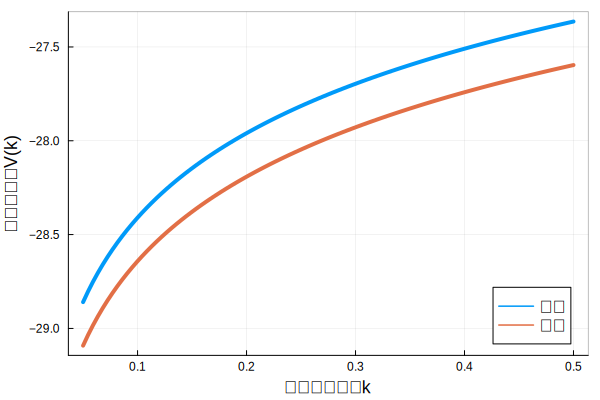

In [53]:
plt = plot(params.kgrid, vfcn0[:, 1],
    legend = :bottomright,
    label = ("好況"),
    xlabel = ("現在の資本：k"),
    ylabel = ("価値関数：V(k)"),
    linewidth = 4,
    titlefont = font("HackGen35Nerd", 12),
    guidefont = font("HackGen35Nerd", 12),
    tickfont = font("HackGen35Nerd", 8),
    legend_font_family = ("HackGen35Nerd"),
    legendfontsize = 12,
    framestyle = :semi
)
plot!(params.kgrid, vfcn0[:, 2], linewidth =4, label="不況")

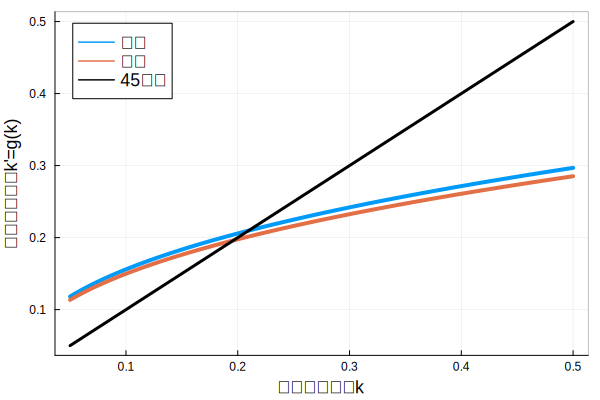

In [50]:
plt = plot(params.kgrid, pfcn0[:, 1],
    legend = :topleft,
    label = ("好況"),
    xlabel = ("現在の資本：k"),
    ylabel = ("次期の資本：k'=g(k)"),
    linewidth = 4,
    titlefont = font("HackGen35Nerd", 12),
    guidefont = font("HackGen35Nerd", 12),
    tickfont = font("HackGen35Nerd", 8),
    legend_font_family = ("HackGen35Nerd"),
    legendfontsize = 12,
    framestyle = :semi
)
plot!(params.kgrid, pfcn0[:, 2], linewidth =4, label="不況")
plot!(params.kgrid, params.kgrid, linewidth = 3, color = "black", linestyle = :dot, label="45度線")

---

## エクササイズ
* 